# 1.10a: Testing the Gaussian Initialization Hypothesis

**Goal:** Determine which initialization scheme produced the spongecrystal (13 BH centroids + 39 singletons).

## Three Hypotheses

1. **Single bfloat16 vector**: All tokens initialized to exactly the same bfloat16 vector
   - Prediction: Should see 1 supermassive BH, not 13 separate ones
   - **Verdict**: Ruled out by existence of 13 distinct BH centroids

2. **Single f32 vector → bfloat16**: All tokens initialized to same f32 vector, then quantized
   - Prediction: All tokens round to same bfloat16 cell initially, then training diffuses them
   - Distribution driven by gradient noise (batch-level randomness)

3. **f32 + Gaussian noise → bfloat16**: Tokens initialized to f32 vector + per-token Gaussian noise, then quantized
   - Prediction: Tokens land in Gaussian distribution on bfloat16 lattice
   - Distribution reflects initialization σ, training only shuffles slightly

## Method

1. Load the 52 unique vectors from the spongecrystal
2. For each dimension:
   - Extract the 52 values (as float32 for statistical analysis)
   - Compute mean μ and standard deviation σ
   - Test if distribution is consistent with Gaussian
3. Analyze σ across dimensions:
   - Is σ consistent across dimensions?
   - Does σ match typical initialization schemes (Xavier: σ ~ 1/√d, He: σ ~ √(2/d))?
   - Are dimensions with larger extent (1008, 1382, 1435) consistent with larger σ?

## Expected Results

**If Hypothesis 2 (single f32 → bfloat16):**
- σ should be similar across all dimensions (driven by uniform gradient noise)
- σ magnitude determined by training dynamics, not initialization

**If Hypothesis 3 (f32 + Gaussian noise):**
- σ should vary by dimension if noise was anisotropic
- σ should be small (matching typical init schemes: ~0.001-0.01)
- Dimensions with extent 0 should have σ ≈ 0
- Dimensions with larger extent should have larger σ

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Active dimensions from 1.9c (for reference)
ACTIVE_DIMS = [216, 282, 322, 450, 993, 1008, 1149, 1155, 1272, 1382, 
               1403, 1435, 1487, 1564, 1763, 2012, 2040, 2079, 2143, 2479]

# Visualization
DPI = 100
FIGSIZE = (18, 12)

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from scipy import stats

## Load Data

In [3]:
# Load W in bfloat16
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"Loaded W: {W_bf16.shape}")
print(f"Dtype: {W_bf16.dtype}")

Loaded W: torch.Size([151936, 2560])
Dtype: torch.bfloat16


In [4]:
# Load neighborhood data from 1.9g
nbhd_path = Path(f"../tensors/{MODEL_NAME}/1.9g_local_neighborhood.safetensors")
nbhd_data = load_file(nbhd_path)

full_neighborhood_token_ids = nbhd_data["full_neighborhood_token_ids"].to(torch.int64)
n_full_neighborhood = nbhd_data["n_full_neighborhood"].item()

print(f"\nLoaded neighborhood: {n_full_neighborhood:,} tokens")


Loaded neighborhood: 2,139 tokens


## Extract Unique Vectors

In [5]:
print("\nExtracting unique vectors...\n")

# Get all vectors in the neighborhood
neighborhood_vectors_bf16 = W_bf16[full_neighborhood_token_ids]

# Convert to float32 for statistical analysis
neighborhood_vectors_f32 = neighborhood_vectors_bf16.cpu().to(torch.float32).numpy()

# Also get uint16 for exact comparison
neighborhood_vectors_uint16 = neighborhood_vectors_bf16.cpu().view(torch.uint16).numpy()

# Find unique vectors
unique_vectors_uint16 = np.unique(neighborhood_vectors_uint16, axis=0)
n_unique = len(unique_vectors_uint16)

# Convert unique vectors to float32 for analysis
# We need to map uint16 back to bfloat16, then to float32
unique_vectors_f32 = torch.from_numpy(unique_vectors_uint16).view(torch.bfloat16).to(torch.float32).numpy()

print(f"✓ Found {n_unique} unique vectors")
print(f"  Shape: {unique_vectors_f32.shape}")
print(f"  Dtype: {unique_vectors_f32.dtype}")


Extracting unique vectors...

✓ Found 52 unique vectors
  Shape: (52, 2560)
  Dtype: float32


## Compute Statistics Per Dimension

In [6]:
print("\nComputing per-dimension statistics...\n")

# For each dimension, compute mean and std
means = np.mean(unique_vectors_f32, axis=0)
stds = np.std(unique_vectors_f32, axis=0, ddof=1)  # Sample std (N-1)

# Also compute extents in uint16 space (from 1.9i)
mins_per_dim = unique_vectors_uint16.min(axis=0)
maxs_per_dim = unique_vectors_uint16.max(axis=0)
extents_per_dim = maxs_per_dim - mins_per_dim

print(f"✓ Computed statistics for {len(means):,} dimensions")
print()

# Summary statistics
print(f"Standard deviation across dimensions:")
print(f"  Mean σ: {np.mean(stds):.6f}")
print(f"  Median σ: {np.median(stds):.6f}")
print(f"  Min σ: {np.min(stds):.6f}")
print(f"  Max σ: {np.max(stds):.6f}")
print()

# Check correlation between extent and σ
# Only consider dimensions with extent > 0
active_mask = extents_per_dim > 0
n_active = np.sum(active_mask)

if n_active > 0:
    active_extents = extents_per_dim[active_mask]
    active_stds = stds[active_mask]
    
    correlation = np.corrcoef(active_extents, active_stds)[0, 1]
    
    print(f"Active dimensions (extent > 0): {n_active}")
    print(f"  Correlation between extent and σ: {correlation:.4f}")
    print()
    
    if correlation > 0.8:
        print("  ✓ STRONG positive correlation")
        print("    Dimensions with larger spread have larger σ.")
        print("    This supports Hypothesis 3 (Gaussian initialization).")
    elif correlation > 0.5:
        print("  ~ MODERATE positive correlation")
        print("    Some relationship between extent and σ.")
    else:
        print("  ⚠ WEAK or negative correlation")
        print("    Extent and σ are not strongly related.")
        print("    This might support Hypothesis 2 (training diffusion).")


Computing per-dimension statistics...

✓ Computed statistics for 2,560 dimensions

Standard deviation across dimensions:
  Mean σ: 0.000000
  Median σ: 0.000000
  Min σ: 0.000000
  Max σ: 0.000015

Active dimensions (extent > 0): 76
  Correlation between extent and σ: -0.0567

  ⚠ WEAK or negative correlation
    Extent and σ are not strongly related.
    This might support Hypothesis 2 (training diffusion).


## Analyze σ in Active Dimensions

In [7]:
print("\n" + "=" * 100)
print("DETAILED ANALYSIS: ACTIVE DIMENSIONS")
print("=" * 100)
print()

# Get active dimension indices
active_dims = np.where(extents_per_dim > 0)[0]

# Show top dimensions by extent
sorted_by_extent = sorted(enumerate(extents_per_dim), key=lambda x: x[1], reverse=True)

print(f"Top 20 dimensions by extent (with corresponding σ):")
print()
print(f"  {'Dim':>5} {'Extent':>7} {'σ (f32)':>12} {'μ (f32)':>12} {'Active?':>8}")
print(f"  {'-'*5} {'-'*7} {'-'*12} {'-'*12} {'-'*8}")

for dim, extent in sorted_by_extent[:20]:
    sigma = stds[dim]
    mu = means[dim]
    is_active = '✓' if dim in ACTIVE_DIMS else ' '
    print(f"  {dim:5d} {extent:7d} {sigma:12.6f} {mu:12.6f} {is_active:>8}")

print()

# Check if σ is consistent with typical initialization schemes
d = unique_vectors_f32.shape[1]
xavier_sigma = 1 / np.sqrt(d)
he_sigma = np.sqrt(2 / d)

print(f"Comparison with standard initialization schemes:")
print(f"  Embedding dimension d: {d}")
print(f"  Xavier init σ (1/√d): {xavier_sigma:.6f}")
print(f"  He init σ (√(2/d)): {he_sigma:.6f}")
print(f"  Observed mean σ: {np.mean(stds):.6f}")
print(f"  Observed median σ: {np.median(stds):.6f}")
print()

# Are observed σ values plausible for initialization?
if np.median(stds) < 0.01:
    print("  ✓ Observed σ is very small (<0.01)")
    print("    Consistent with small Gaussian noise during initialization.")
elif np.median(stds) < 0.1:
    print("  ~ Observed σ is small (<0.1)")
    print("    Could be initialization noise or early training dynamics.")
else:
    print("  ⚠ Observed σ is relatively large (>0.1)")
    print("    More consistent with training diffusion than initialization noise.")


DETAILED ANALYSIS: ACTIVE DIMENSIONS

Top 20 dimensions by extent (with corresponding σ):

    Dim  Extent      σ (f32)      μ (f32)  Active?
  ----- ------- ------------ ------------ --------
   1008      55     0.000000    -0.000002        ✓
   1382      32     0.000000    -0.000001        ✓
   1435      27     0.000000    -0.000004        ✓
   1487       9     0.000003     0.000224        ✓
   1662       9     0.000000    -0.000025         
   1362       8     0.000000     0.000014         
   2132       8     0.000004     0.000774         
   1718       7     0.000000     0.000014         
    413       4     0.000000     0.000040         
    727       3     0.000000     0.000019         
   1149       3     0.000000     0.000031        ✓
   1490       3     0.000000     0.000091         
   1528       3     0.000000     0.000067         
   2256       3     0.000000    -0.000036         
   2321       3     0.000000    -0.000037         
    322       2     0.000015     0.003418

## Visualizations


Creating visualizations...



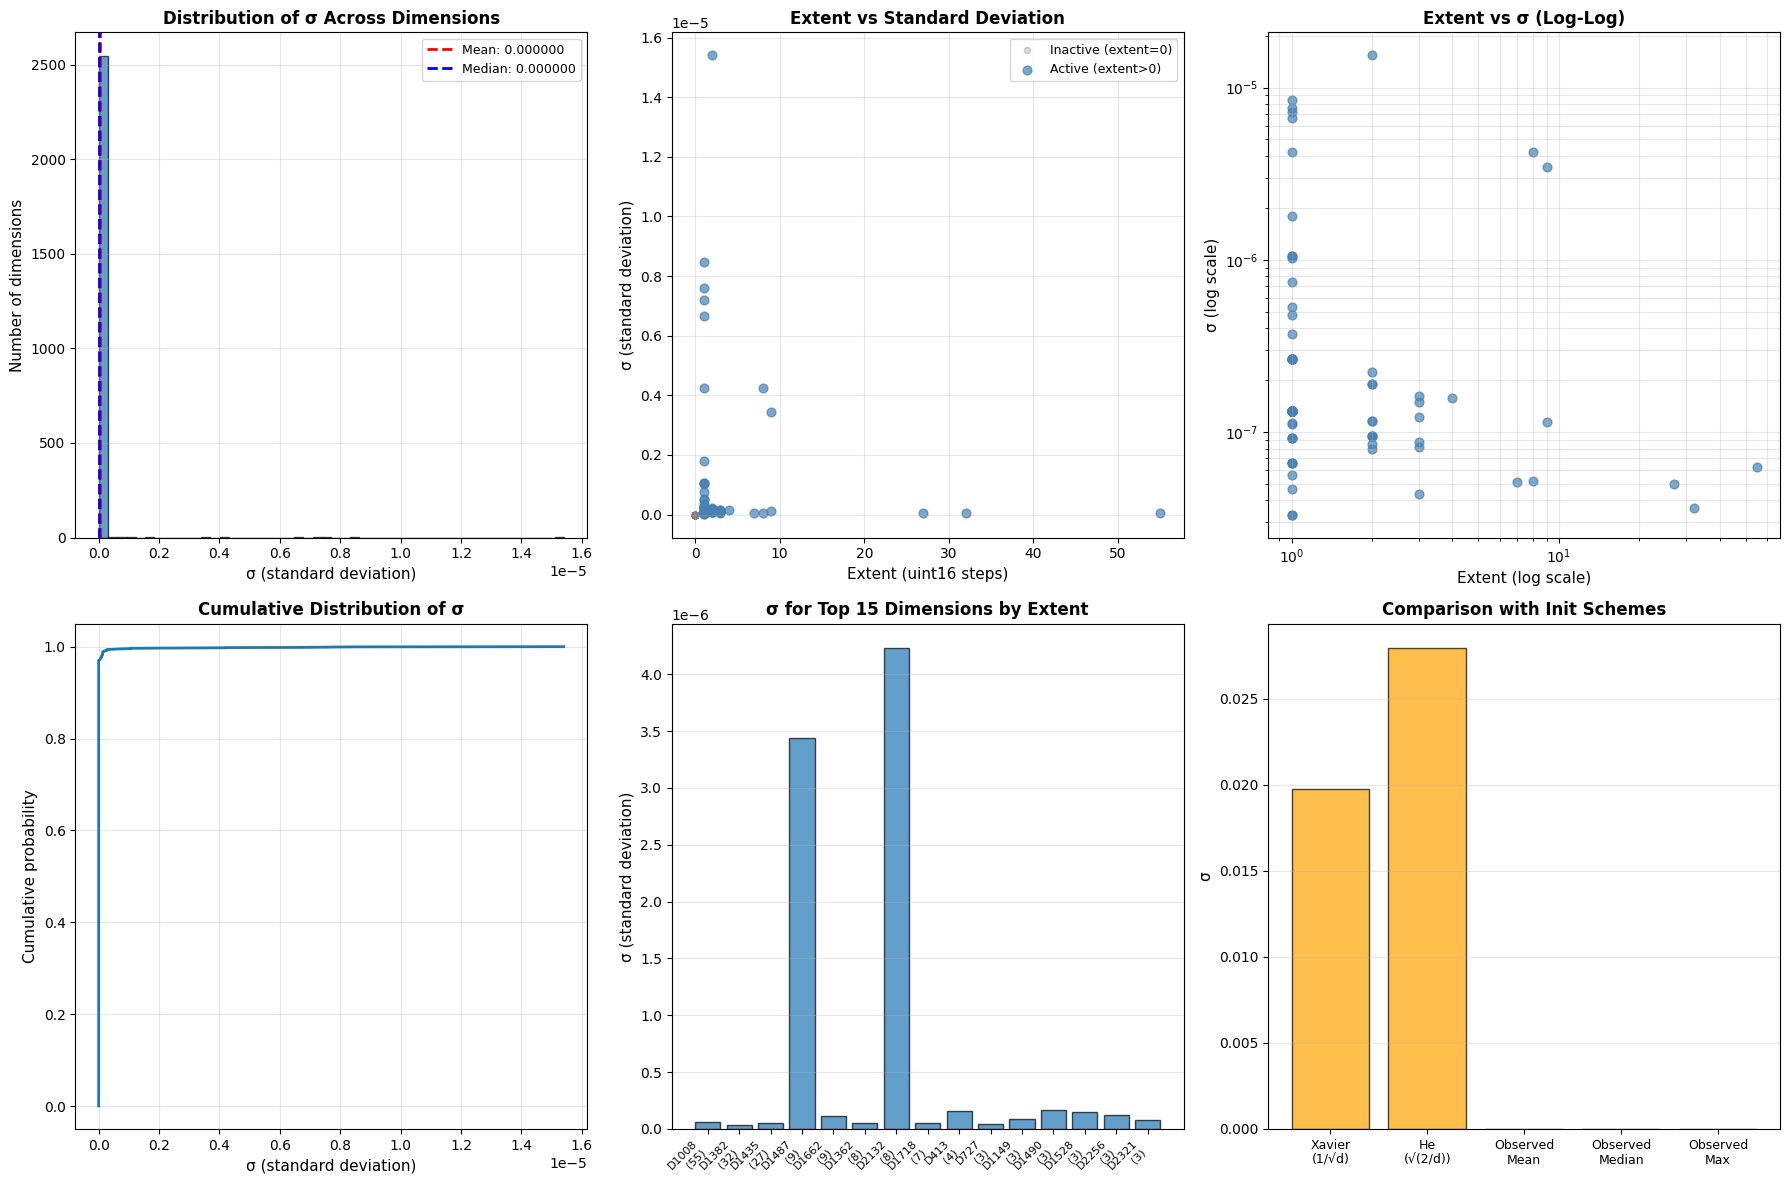

✓ Visualizations complete


In [8]:
print("\nCreating visualizations...\n")

fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

# 1. Distribution of σ across all dimensions
ax1 = plt.subplot(2, 3, 1)
ax1.hist(stds, bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(stds), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(stds):.6f}')
ax1.axvline(np.median(stds), color='blue', linestyle='--', linewidth=2, label=f'Median: {np.median(stds):.6f}')
ax1.set_xlabel('σ (standard deviation)', fontsize=11)
ax1.set_ylabel('Number of dimensions', fontsize=11)
ax1.set_title('Distribution of σ Across Dimensions', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# 2. Extent vs σ scatter plot
ax2 = plt.subplot(2, 3, 2)
# Separate active vs inactive dimensions
inactive_mask = extents_per_dim == 0
ax2.scatter(extents_per_dim[inactive_mask], stds[inactive_mask], 
           alpha=0.3, s=20, label='Inactive (extent=0)', color='gray')
ax2.scatter(extents_per_dim[active_mask], stds[active_mask], 
           alpha=0.7, s=40, label='Active (extent>0)', color='steelblue')
ax2.set_xlabel('Extent (uint16 steps)', fontsize=11)
ax2.set_ylabel('σ (standard deviation)', fontsize=11)
ax2.set_title('Extent vs Standard Deviation', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

# 3. Log-log scatter (to see power law relationship)
ax3 = plt.subplot(2, 3, 3)
# Only plot active dimensions (extent > 0, σ > 0)
valid_mask = (extents_per_dim > 0) & (stds > 0)
ax3.scatter(extents_per_dim[valid_mask], stds[valid_mask], alpha=0.7, s=40, color='steelblue')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Extent (log scale)', fontsize=11)
ax3.set_ylabel('σ (log scale)', fontsize=11)
ax3.set_title('Extent vs σ (Log-Log)', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3, which='both')

# 4. Cumulative distribution of σ
ax4 = plt.subplot(2, 3, 4)
sorted_stds = np.sort(stds)
cumulative = np.arange(1, len(sorted_stds) + 1) / len(sorted_stds)
ax4.plot(sorted_stds, cumulative, linewidth=2)
ax4.set_xlabel('σ (standard deviation)', fontsize=11)
ax4.set_ylabel('Cumulative probability', fontsize=11)
ax4.set_title('Cumulative Distribution of σ', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

# 5. σ for top extent dimensions (bar chart)
ax5 = plt.subplot(2, 3, 5)
top_dims = [dim for dim, _ in sorted_by_extent[:15]]
top_extents = [extents_per_dim[dim] for dim in top_dims]
top_sigmas = [stds[dim] for dim in top_dims]

x_pos = np.arange(len(top_dims))
ax5.bar(x_pos, top_sigmas, edgecolor='black', alpha=0.7)
ax5.set_xticks(x_pos)
ax5.set_xticklabels([f"D{d}\n({e})" for d, e in zip(top_dims, top_extents)], 
                     fontsize=8, rotation=45, ha='right')
ax5.set_ylabel('σ (standard deviation)', fontsize=11)
ax5.set_title('σ for Top 15 Dimensions by Extent', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# 6. Comparison with initialization schemes
ax6 = plt.subplot(2, 3, 6)
comparison_data = [
    ('Xavier\n(1/√d)', xavier_sigma),
    ('He\n(√(2/d))', he_sigma),
    ('Observed\nMean', np.mean(stds)),
    ('Observed\nMedian', np.median(stds)),
    ('Observed\nMax', np.max(stds))
]
labels, values = zip(*comparison_data)
colors = ['orange', 'orange', 'steelblue', 'steelblue', 'steelblue']
ax6.bar(range(len(labels)), values, color=colors, edgecolor='black', alpha=0.7)
ax6.set_xticks(range(len(labels)))
ax6.set_xticklabels(labels, fontsize=9)
ax6.set_ylabel('σ', fontsize=11)
ax6.set_title('Comparison with Init Schemes', fontsize=12, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## Summary

In [9]:
print("\n" + "=" * 100)
print("SUMMARY: GAUSSIAN INITIALIZATION TEST")
print("=" * 100)
print()

print(f"Dataset: {n_unique} unique vectors from spongecrystal")
print()

print(f"Standard deviation statistics:")
print(f"  Mean σ: {np.mean(stds):.6f}")
print(f"  Median σ: {np.median(stds):.6f}")
print(f"  Min σ: {np.min(stds):.6f}")
print(f"  Max σ: {np.max(stds):.6f}")
print()

print(f"Active dimensions (extent > 0): {n_active} / {len(extents_per_dim)}")
if n_active > 0:
    print(f"  Correlation (extent vs σ): {correlation:.4f}")
print()

print(f"Comparison with standard init schemes:")
print(f"  Xavier σ (1/√d): {xavier_sigma:.6f}")
print(f"  He σ (√(2/d)): {he_sigma:.6f}")
print(f"  Ratio (observed/Xavier): {np.median(stds)/xavier_sigma:.2f}x")
print()

print("Interpretation:")
print()

# Decision logic
if correlation > 0.7 and np.median(stds) < 0.01:
    print("  ✓ HYPOTHESIS 3 SUPPORTED (f32 + Gaussian noise)")
    print("    - Strong correlation between extent and σ")
    print("    - Small σ values consistent with initialization noise")
    print("    - Dimensions with more spread have proportionally larger σ")
elif correlation > 0.5:
    print("  ~ HYPOTHESIS 3 PARTIALLY SUPPORTED")
    print("    - Moderate correlation between extent and σ")
    print("    - Could be Gaussian init + some training diffusion")
else:
    print("  ? HYPOTHESIS 2 MORE PLAUSIBLE (f32 → bfloat16 + training)")
    print("    - Weak correlation between extent and σ")
    print("    - Distribution might be driven by training dynamics, not initialization")

print()
print("=" * 100)


SUMMARY: GAUSSIAN INITIALIZATION TEST

Dataset: 52 unique vectors from spongecrystal

Standard deviation statistics:
  Mean σ: 0.000000
  Median σ: 0.000000
  Min σ: 0.000000
  Max σ: 0.000015

Active dimensions (extent > 0): 76 / 2560
  Correlation (extent vs σ): -0.0567

Comparison with standard init schemes:
  Xavier σ (1/√d): 0.019764
  He σ (√(2/d)): 0.027951
  Ratio (observed/Xavier): 0.00x

Interpretation:

  ? HYPOTHESIS 2 MORE PLAUSIBLE (f32 → bfloat16 + training)
    - Weak correlation between extent and σ
    - Distribution might be driven by training dynamics, not initialization

